### Load packages

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
import igraph as ig
import contextily as ctx
from rasterstats import zonal_stats
import time
import pylab as pl
from IPython import display
import seaborn as sns
import subprocess

from shapely.wkb import loads

data_path = os.path.join('..','data')

# path to python scripts
sys.path.append(os.path.join('..','src','trails'))

from flow_model import *
from simplify import *
from extract import railway,ferries,mainRoads,roads


pd.options.mode.chained_assignment = None  

In [2]:
#comtrade_stats = pd.read_csv(os.path.join(data_path,'comtrade.csv'))
#comtrade_stats = comtrade_stats.loc[comtrade_stats['Netweight (kg)'] > 0].reset_index(drop=True)
#comtrade_stats['avg_kg_value'] = comtrade_stats['Trade Value (US$)']/comtrade_stats['Netweight (kg)']

In [3]:
country = 'FJI'

In [55]:
def create_graph(gdf_roads):
    """[summary]

    Args:
        gdf_roads ([type]): [description]

    Returns:
        [type]: [description]
    """    
    gdf_in = gdf_roads.reindex(['from_id','to_id'] + [x for x in list(gdf_roads.columns) if x not in ['from_id','to_id']],axis=1)

    g = ig.Graph.TupleList(gdf_in.itertuples(index=False), edge_attrs=list(gdf_in.columns)[2:],directed=True)
    sg = g.clusters().giant()

    gdf_in.set_index('id',inplace=True)
    
    return sg,gdf_in

In [67]:
osm_path = os.path.join(r'C:\Data\country_osm','{}.osm.pbf'.format(country))

transport_network = load_network(osm_path)
print('NOTE: Network created')

gdf_roads = prepare_network_routing(transport_network)
sg = create_graph(gdf_roads)[0]
main_graph = pd.DataFrame(list(sg.es['geometry']),columns=['geometry'])
main_network = pd.DataFrame([list(sg.es[x]) for x in sg.es.attribute_names()]).T
main_network.columns = sg.es.attribute_names()

data_path = os.path.join('..','Data')

query is finished, lets start the loop


topology: 100%|██████████████████████████████████████████████████████████████████| 1654/1654 [00:00<00:00, 2339.53it/s]


0  Edges not connected to nodes
NOTE: Network created


In [68]:
def country_grid_gdp_filled(trans_network,country,data_path,rough_grid_split=100,from_main_graph=False):
    """[summary]

    Args:
        trans_network ([type]): [description]
        rough_grid_split (int, optional): [description]. Defaults to 100.

    Returns:
        [type]: [description]
    """    
    if from_main_graph==True:
        node_df = trans_network.copy()
        envelop = pygeos.envelope(pygeos.multilinestrings(node_df.geometry.values))
        height = np.sqrt(pygeos.area(envelop)/rough_grid_split)        
    else:
        node_df = trans_network.copy()
        node_df.geometry,approximate_crs = convert_crs(node_df)
        envelop = pygeos.envelope(pygeos.multilinestrings(node_df.geometry.values))
        height = np.sqrt(pygeos.area(envelop)/rough_grid_split)    

    gdf_admin = pd.DataFrame(create_grid(create_bbox(node_df),height),columns=['geometry'])
   
     #load data and convert to pygeos
    country_shape = gpd.read_file(os.path.join(data_path,'GADM','gadm36_levels.gpkg'),layer=0)
    country_shape = pd.DataFrame(country_shape.loc[country_shape.GID_0==country])
    country_shape.geometry = pygeos.from_shapely(country_shape.geometry)

    gdf_admin = pygeos.intersection(gdf_admin,country_shape.geometry)
    gdf_admin = gdf_admin.loc[~pygeos.is_empty(gdf_admin.geometry)]
      
    gdf_admin['centroid'] = pygeos.centroid(gdf_admin.geometry)
    gdf_admin['km2'] = area(gdf_admin)
    gdf_admin['gdp'] = get_gdp_values(gdf_admin,data_path)
    gdf_admin = gdf_admin.loc[gdf_admin.gdp > 0].reset_index()
    gdf_admin['gdp_area'] = gdf_admin.gdp/gdf_admin['km2']

    return gdf_admin


In [72]:
gdf_admin = country_grid_gdp_filled(main_graph,country,data_path,rough_grid_split=100,from_main_graph=True)

print('NOTE: GDP values extracted')

OD,OD_dict,sectors,gdf_admin = create_OD(gdf_admin,country,data_path)
print('NOTE: OD created')

NOTE: GDP values extracted
NOTE: OD created


In [73]:
def run_flow_analysis(country,transport_network,gdf_admin,OD_dict,notebook=False):
    """[summary]

    Args:
        transport_network ([type]): [description]
        gdf_admin ([type]): [description]

    Returns:
        [type]: [description]
    """    
    plt.rcParams['figure.figsize'] = [5, 5]

    gdf_roads = prepare_network_routing(transport_network)
    sg,gdf_in = create_graph(gdf_roads)
        
    nearest_node = nearest_network_node_list(gdf_admin,transport_network.nodes,sg)
    dest_nodes = [sg.vs['name'].index(nearest_node[x]) for x in list(nearest_node.keys())]

    # this is where the iterations goes
    iterator = 0
    optimal = False
    max_iter = 100
    save_fits = []

    if not notebook:
        plt.ion() ## Note this correction

    while optimal == False:
        sg.es['GC'] = [(lambda segment: update_gc_function(segment))(segment) for segment in list(sg.es)]
        sg.es['flow'] = 0
        for admin_orig in (list(gdf_admin.name)):
            paths = sg.get_shortest_paths(sg.vs[sg.vs['name'].index(nearest_node[admin_orig])],dest_nodes,weights='GC',output="epath")
            for path,admin_dest in zip(paths,list(gdf_admin.name)):
                flow_value = OD_dict[(admin_orig,admin_dest)]
                sg.es[path]['flow'] = [x + flow_value for x in sg.es[path]['flow']] 

        fitting_edges = (sum([x<y for x,y in zip(sg.es['flow'],sg.es['max_flow'])])/len(sg.es))
        save_fits.append(fitting_edges)
        if (sum([x<y for x,y in zip(sg.es['flow'],sg.es['max_flow'])])/len(sg.es)) > 0.99:
            optimal = True
        iterator += 1

        if notebook:
            pl.plot(save_fits) 
            display.display(pl.gcf())
            display.clear_output(wait=True) 
        else:
            plt.plot(save_fits) 
            plt.xlabel('# iteration')
            plt.ylabel('Share of edges below maximum flow')
            plt.show()
            plt.pause(0.0001) #Note this correction

        if iterator == max_iter:
            break    
            
    plt.savefig(os.path.join(code_path,'..','..','figures','{}_flow_modelling.png'.format(country)))   
    gdf_in['flow'] = pd.DataFrame(sg.es['flow'],columns=['flow'],index=sg.es['id'])
    gdf_in['max_flow'] = pd.DataFrame(sg.es['max_flow'],columns=['max_flow'],index=sg.es['id'])
    gdf_in['wait_time'] = pd.DataFrame(sg.es['wait_time'],columns=['wait_time'],index=sg.es['id'])
    gdf_in['overflow'] = gdf_in['flow'].div(gdf_in['max_flow'])   
    
    return gdf_in

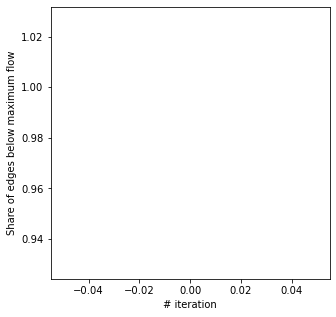

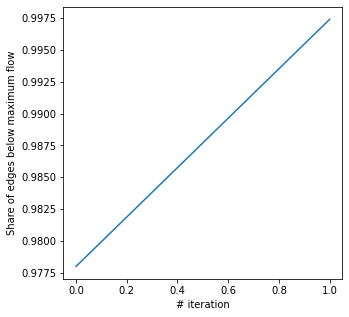

NOTE: Flow analysis finished


<Figure size 360x360 with 0 Axes>

In [74]:
gdf_out = run_flow_analysis(country,transport_network,gdf_admin,OD_dict)
print('NOTE: Flow analysis finished')

In [75]:
#gdf_admin['geometry'] = gdf_admin.geometry.apply(lambda x: loads(pygeos.to_wkb(x)))
gdf_out = gdf_out.loc[~gdf_out.max_flow.isna()].reset_index(drop=True)
gdf_out_save = gdf_out.copy()
gdf_out_save['geometry'] = gdf_out_save.geometry.apply(lambda x: loads(pygeos.to_wkb(x)))               

gpd.GeoDataFrame(gdf_admin.drop('centroid',axis=1)).to_file(
    os.path.join('..','data',
    '{}.gpkg'.format(country)),layer='grid',driver='GPKG')
gpd.GeoDataFrame(gdf_out_save).to_file(os.path.join('..','data',
    '{}.gpkg'.format(country)),layer='network',driver='GPKG')